# Credit

This notebook is based on the following notebook by @yasufuminakama. I would like to take this opportunity to thank him.

Please vote for his notebook as well.

https://www.kaggle.com/yasufuminakama/cassava-resnext50-32x4d-starter-training

# Summary of this notebook

In this notebook, we are gonna build the nocall detector. (0:nocall, 1:somebird singing)

The output of the models would be probability value.

# input & output of this notebook

[input]

freefield1010 data

https://www.kaggle.com/startjapan/ff1010bird-duration7

[output]

Nocall detector models are outputted.

In [96]:
import os

OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [97]:
import torch

class CFG:
    print_freq=100
    num_workers=4
    model_name= 'resnext50_32x4d'
    dim=(128, 281)
    scheduler='CosineAnnealingWarmRestarts'
    epochs=10
    lr=1e-4
    T_0=10 # for CosineAnnealingWarmRestarts
    min_lr=5e-7 # for CosineAnnealingWarmRestarts
    batch_size=32
    weight_decay=1e-6
    max_grad_norm=1000
    seed=42
    target_size=2
    target_col='hasbird'
    n_fold = 5
    pretrained = True
    #device = 'cpu'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [98]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd

train = pd.read_csv('../input/rich_metadata.csv')
train.loc[train['hasbird']==0, 'filepath'] = '../input/nocall/' + train.query('hasbird==0')['filename'] + '.npy'
train.loc[train['hasbird']==1, 'filepath'] = '../input/bird/' + train.query('hasbird==1')['filename'] + '.npy'

train = train.dropna().reset_index(drop=True)

folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, 'fold'] = int(n)
folds['fold'] = folds['fold'].astype(int)
print(folds.groupby(['fold', CFG.target_col]).size())

fold  hasbird
0     0          1151
      1           387
1     0          1151
      1           387
2     0          1151
      1           387
3     0          1151
      1           387
4     0          1151
      1           387
dtype: int64


In [99]:
import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold

from tqdm.auto import tqdm
from functools import partial

import cv2
from PIL import Image

import cv2
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

!pip install timm
import timm

import warnings 
warnings.filterwarnings('ignore')

In [100]:
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)

def get_confusion_matrix(y_true, y_pred):
    return confusion_matrix(y_true, y_pred)

@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f'[{name}] start')
    yield
    LOGGER.info(f'[{name}] done in {time.time() - t0:.0f} s.')


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=CFG.seed)

In [101]:
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_paths = df['filepath'].values
        self.labels = df['hasbird'].values
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_paths[idx]
        file_path = file_name
        image = np.load(file_path)
        image = image.transpose(1,2,0)
        image = np.squeeze(image)
        image = np.stack((image,)*3, -1)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        label = torch.tensor(self.labels[idx]).long()
        return image, label

In [102]:
def get_transforms(*, data):
    
    if data == 'train':
        return A.Compose([
            A.Resize(CFG.dim[0], CFG.dim[1]),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.augmentations.transforms.JpegCompression(p=0.5),
            A.augmentations.transforms.ImageCompression(p=0.5, compression_type=A.augmentations.transforms.ImageCompression.ImageCompressionType.WEBP),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            A.Resize(CFG.dim[0], CFG.dim[1]),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(),
        ])

In [103]:
class CustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.fc.in_features
        self.model.fc = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [104]:
# Necessary imports

import numpy as np
import matplotlib.pyplot as plt

from torch import Tensor
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

from qiskit import QuantumCircuit
from qiskit.utils import algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

# Set seed for random generators
algorithm_globals.random_seed = 42

# we decompose the circuit for the QNN to avoid additional data copying
# Define and create QNN
nq=2
def create_qnn():
    feature_map = ZZFeatureMap(nq)
    ansatz = RealAmplitudes(nq, reps=1)
    qc = QuantumCircuit(nq)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = SamplerQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn


qnn4 = create_qnn()

In [105]:
from qiskit_machine_learning.connectors import TorchConnector
from torch import cat, no_grad, manual_seed

In [106]:
class QuantumCustomResNext(nn.Module):
    def __init__(self, model_name='resnext50_32x4d', pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        self.fc = nn.Linear(512, nq)    
        self.qnn = TorchConnector(qnn4)
        self.fc2 = nn.Linear(pow(2, nq), CFG.target_size)
        
        # Remove fully connected layer and last two blocks
        self.model.fc = nn.Identity()
        self.model.layer4 = nn.Identity()
        self.model.layer3 = nn.Identity()

    def forward(self, x):
        x = self.model(x)
        x = self.fc(x)
        x = self.qnn(x)
        x = self.fc2(x)
        
        return x

In [107]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        y_preds = model(images)
        loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        
        optimizer.step()
        optimizer.zero_grad()
        global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  .format(
                   epoch+1, step+1, len(train_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(train_loader)),
                   grad_norm=grad_norm,
                   ))
    return losses.avg

def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to('cpu').numpy())
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Data {data_time.val:.3f} ({data_time.avg:.3f}) '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step+1, len(valid_loader), batch_time=batch_time,
                   data_time=data_time, loss=losses,
                   remain=timeSince(start, float(step+1)/len(valid_loader)),
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

In [108]:
from torchsummary import summary

def train_loop(train_folds, valid_folds):

    LOGGER.info(f"========== training ==========")

    # ====================================================
    # loader
    # ====================================================
    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    def get_scheduler(optimizer):
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = QuantumCustomResNext(CFG.model_name, pretrained=True)
    #model = CustomResNext(CFG.model_name, pretrained=True)
    model.to(CFG.device)
    
    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    #criterion = nn.CrossEntropyLoss()
    criterion = nn.NLLLoss()
    best_score = 0.
    best_loss = np.inf
    
    summary(model, (3, 224, 224))
    
    scores = []
    
    for epoch in range(CFG.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, CFG.device)
        
        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, CFG.device)
        valid_labels = valid_folds[CFG.target_col].values
        
        scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Accuracy: {score}')
        
        scores.append(score)
        
        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_best.pth')
    
    check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_best.pth')
    valid_folds[[str(c) for c in range(CFG.target_size)]] = check_point['preds']
    valid_folds['preds'] = check_point['preds'].argmax(1)

    return valid_folds, scores

In [109]:
def main(fold):
    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.5f}')
    
    def get_result2(result_df):
        preds = result_df['preds'].values
        labels = result_df[CFG.target_col].values
        matrix = get_confusion_matrix(labels, preds)
        print('TN', matrix[0,0])
        print('FP', matrix[0,1])
        print('FN', matrix[1,0])
        print('TP', matrix[1,1])
    
    # train 
    train_folds = folds.query(f'fold!={fold}').reset_index(drop=True)
    valid_folds = folds.query(f'fold=={fold}').reset_index(drop=False)
    oof_df, scores = train_loop(train_folds, valid_folds)
    # CV result
    LOGGER.info(f"========== CV ==========")
    get_result(oof_df)
    get_result2(oof_df)
    # save result
    oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)
    plt.plot([i for i in range(CFG.epochs)], scores)
    plt.title('valid score')
    plt.show()

========== training ==========
========== training ==========
========== training ==========
========== training ==========
========== training ==========
========== training ==========


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]           8,192
       BatchNorm2d-6          [-1, 128, 56, 56]             256
              ReLU-7          [-1, 128, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]           4,608
       BatchNorm2d-9          [-1, 128, 56, 56]             256
         Identity-10          [-1, 128, 56, 56]               0
             ReLU-11          [-1, 128, 56, 56]               0
         Identity-12          [-1, 128, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]          32,768
      BatchNorm2d-14          [-1, 256,

Epoch 1 - avg_train_loss: -0.1258  avg_val_loss: -0.1398  time: 152s
Epoch 1 - avg_train_loss: -0.1258  avg_val_loss: -0.1398  time: 152s
Epoch 1 - avg_train_loss: -0.1258  avg_val_loss: -0.1398  time: 152s
Epoch 1 - avg_train_loss: -0.1258  avg_val_loss: -0.1398  time: 152s
Epoch 1 - avg_train_loss: -0.1258  avg_val_loss: -0.1398  time: 152s
Epoch 1 - avg_train_loss: -0.1258  avg_val_loss: -0.1398  time: 152s
Epoch 1 - Accuracy: 0.5812743823146944
Epoch 1 - Accuracy: 0.5812743823146944
Epoch 1 - Accuracy: 0.5812743823146944
Epoch 1 - Accuracy: 0.5812743823146944
Epoch 1 - Accuracy: 0.5812743823146944
Epoch 1 - Accuracy: 0.5812743823146944
Epoch 1 - Save Best Score: 0.5813 Model
Epoch 1 - Save Best Score: 0.5813 Model
Epoch 1 - Save Best Score: 0.5813 Model
Epoch 1 - Save Best Score: 0.5813 Model
Epoch 1 - Save Best Score: 0.5813 Model
Epoch 1 - Save Best Score: 0.5813 Model


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 4s (remain 0m 0s) Loss: -0.0383(-0.1398) 
Epoch: [2][1/192] Data 0.337 (0.337) Elapsed 0m 1s (remain 4m 2s) Loss: -0.1375(-0.1375) Grad: 22.6017  
Epoch: [2][101/192] Data 0.000 (0.004) Elapsed 1m 20s (remain 1m 12s) Loss: -0.2104(-0.1664) Grad: 57.3096  
Epoch: [2][192/192] Data 0.000 (0.002) Elapsed 2m 32s (remain 0m 0s) Loss: -0.2137(-0.1847) Grad: 15.0060  
EVAL: [1/49] Data 0.141 (0.141) Elapsed 0m 0s (remain 0m 12s) Loss: -0.2668(-0.2668) 


Epoch 2 - avg_train_loss: -0.1847  avg_val_loss: -0.2366  time: 156s
Epoch 2 - avg_train_loss: -0.1847  avg_val_loss: -0.2366  time: 156s
Epoch 2 - avg_train_loss: -0.1847  avg_val_loss: -0.2366  time: 156s
Epoch 2 - avg_train_loss: -0.1847  avg_val_loss: -0.2366  time: 156s
Epoch 2 - avg_train_loss: -0.1847  avg_val_loss: -0.2366  time: 156s
Epoch 2 - avg_train_loss: -0.1847  avg_val_loss: -0.2366  time: 156s
Epoch 2 - Accuracy: 0.6742522756827048
Epoch 2 - Accuracy: 0.6742522756827048
Epoch 2 - Accuracy: 0.6742522756827048
Epoch 2 - Accuracy: 0.6742522756827048
Epoch 2 - Accuracy: 0.6742522756827048
Epoch 2 - Accuracy: 0.6742522756827048
Epoch 2 - Save Best Score: 0.6743 Model
Epoch 2 - Save Best Score: 0.6743 Model
Epoch 2 - Save Best Score: 0.6743 Model
Epoch 2 - Save Best Score: 0.6743 Model
Epoch 2 - Save Best Score: 0.6743 Model
Epoch 2 - Save Best Score: 0.6743 Model


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 3s (remain 0m 0s) Loss: -0.0938(-0.2366) 
Epoch: [3][1/192] Data 0.322 (0.322) Elapsed 0m 1s (remain 4m 34s) Loss: -0.2441(-0.2441) Grad: 34.0347  
Epoch: [3][101/192] Data 0.000 (0.003) Elapsed 1m 20s (remain 1m 12s) Loss: -0.3082(-0.2545) Grad: 18.2647  
Epoch: [3][192/192] Data 0.000 (0.002) Elapsed 2m 28s (remain 0m 0s) Loss: -0.2448(-0.2748) Grad: 68.2233  
EVAL: [1/49] Data 0.124 (0.124) Elapsed 0m 0s (remain 0m 11s) Loss: -0.3498(-0.3498) 


Epoch 3 - avg_train_loss: -0.2748  avg_val_loss: -0.3208  time: 153s
Epoch 3 - avg_train_loss: -0.2748  avg_val_loss: -0.3208  time: 153s
Epoch 3 - avg_train_loss: -0.2748  avg_val_loss: -0.3208  time: 153s
Epoch 3 - avg_train_loss: -0.2748  avg_val_loss: -0.3208  time: 153s
Epoch 3 - avg_train_loss: -0.2748  avg_val_loss: -0.3208  time: 153s
Epoch 3 - avg_train_loss: -0.2748  avg_val_loss: -0.3208  time: 153s
Epoch 3 - Accuracy: 0.764629388816645
Epoch 3 - Accuracy: 0.764629388816645
Epoch 3 - Accuracy: 0.764629388816645
Epoch 3 - Accuracy: 0.764629388816645
Epoch 3 - Accuracy: 0.764629388816645
Epoch 3 - Accuracy: 0.764629388816645
Epoch 3 - Save Best Score: 0.7646 Model
Epoch 3 - Save Best Score: 0.7646 Model
Epoch 3 - Save Best Score: 0.7646 Model
Epoch 3 - Save Best Score: 0.7646 Model
Epoch 3 - Save Best Score: 0.7646 Model
Epoch 3 - Save Best Score: 0.7646 Model


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 3s (remain 0m 0s) Loss: -0.0630(-0.3208) 
Epoch: [4][1/192] Data 0.310 (0.310) Elapsed 0m 1s (remain 4m 10s) Loss: -0.3325(-0.3325) Grad: 10.7150  
Epoch: [4][101/192] Data 0.000 (0.003) Elapsed 1m 16s (remain 1m 9s) Loss: -0.3971(-0.3324) Grad: 9.6442  
Epoch: [4][192/192] Data 0.000 (0.002) Elapsed 2m 29s (remain 0m 0s) Loss: -0.2766(-0.3402) Grad: 52.8064  
EVAL: [1/49] Data 0.139 (0.139) Elapsed 0m 0s (remain 0m 10s) Loss: -0.3617(-0.3617) 


Epoch 4 - avg_train_loss: -0.3402  avg_val_loss: -0.3633  time: 153s
Epoch 4 - avg_train_loss: -0.3402  avg_val_loss: -0.3633  time: 153s
Epoch 4 - avg_train_loss: -0.3402  avg_val_loss: -0.3633  time: 153s
Epoch 4 - avg_train_loss: -0.3402  avg_val_loss: -0.3633  time: 153s
Epoch 4 - avg_train_loss: -0.3402  avg_val_loss: -0.3633  time: 153s
Epoch 4 - avg_train_loss: -0.3402  avg_val_loss: -0.3633  time: 153s
Epoch 4 - Accuracy: 0.7841352405721717
Epoch 4 - Accuracy: 0.7841352405721717
Epoch 4 - Accuracy: 0.7841352405721717
Epoch 4 - Accuracy: 0.7841352405721717
Epoch 4 - Accuracy: 0.7841352405721717
Epoch 4 - Accuracy: 0.7841352405721717
Epoch 4 - Save Best Score: 0.7841 Model
Epoch 4 - Save Best Score: 0.7841 Model
Epoch 4 - Save Best Score: 0.7841 Model
Epoch 4 - Save Best Score: 0.7841 Model
Epoch 4 - Save Best Score: 0.7841 Model
Epoch 4 - Save Best Score: 0.7841 Model


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 4s (remain 0m 0s) Loss: -0.1504(-0.3633) 
Epoch: [5][1/192] Data 0.266 (0.266) Elapsed 0m 1s (remain 3m 56s) Loss: -0.3960(-0.3960) Grad: 34.4477  
Epoch: [5][101/192] Data 0.000 (0.003) Elapsed 1m 19s (remain 1m 11s) Loss: -0.4390(-0.3742) Grad: 31.9056  
Epoch: [5][192/192] Data 0.000 (0.002) Elapsed 2m 26s (remain 0m 0s) Loss: -0.3364(-0.3859) Grad: 19.0586  
EVAL: [1/49] Data 0.144 (0.144) Elapsed 0m 0s (remain 0m 12s) Loss: -0.3933(-0.3933) 


Epoch 5 - avg_train_loss: -0.3859  avg_val_loss: -0.3838  time: 151s
Epoch 5 - avg_train_loss: -0.3859  avg_val_loss: -0.3838  time: 151s
Epoch 5 - avg_train_loss: -0.3859  avg_val_loss: -0.3838  time: 151s
Epoch 5 - avg_train_loss: -0.3859  avg_val_loss: -0.3838  time: 151s
Epoch 5 - avg_train_loss: -0.3859  avg_val_loss: -0.3838  time: 151s
Epoch 5 - avg_train_loss: -0.3859  avg_val_loss: -0.3838  time: 151s
Epoch 5 - Accuracy: 0.7711313394018205
Epoch 5 - Accuracy: 0.7711313394018205
Epoch 5 - Accuracy: 0.7711313394018205
Epoch 5 - Accuracy: 0.7711313394018205
Epoch 5 - Accuracy: 0.7711313394018205
Epoch 5 - Accuracy: 0.7711313394018205


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 4s (remain 0m 0s) Loss: -0.1126(-0.3838) 
Epoch: [6][1/192] Data 0.289 (0.289) Elapsed 0m 1s (remain 5m 3s) Loss: -0.4388(-0.4388) Grad: 33.8708  
Epoch: [6][101/192] Data 0.000 (0.003) Elapsed 1m 15s (remain 1m 7s) Loss: -0.4275(-0.4120) Grad: 24.5139  
Epoch: [6][192/192] Data 0.000 (0.002) Elapsed 2m 21s (remain 0m 0s) Loss: -0.3663(-0.4233) Grad: 28.1172  
EVAL: [1/49] Data 0.139 (0.139) Elapsed 0m 0s (remain 0m 11s) Loss: -0.4337(-0.4337) 


Epoch 6 - avg_train_loss: -0.4233  avg_val_loss: -0.4208  time: 146s
Epoch 6 - avg_train_loss: -0.4233  avg_val_loss: -0.4208  time: 146s
Epoch 6 - avg_train_loss: -0.4233  avg_val_loss: -0.4208  time: 146s
Epoch 6 - avg_train_loss: -0.4233  avg_val_loss: -0.4208  time: 146s
Epoch 6 - avg_train_loss: -0.4233  avg_val_loss: -0.4208  time: 146s
Epoch 6 - avg_train_loss: -0.4233  avg_val_loss: -0.4208  time: 146s
Epoch 6 - Accuracy: 0.7860858257477243
Epoch 6 - Accuracy: 0.7860858257477243
Epoch 6 - Accuracy: 0.7860858257477243
Epoch 6 - Accuracy: 0.7860858257477243
Epoch 6 - Accuracy: 0.7860858257477243
Epoch 6 - Accuracy: 0.7860858257477243
Epoch 6 - Save Best Score: 0.7861 Model
Epoch 6 - Save Best Score: 0.7861 Model
Epoch 6 - Save Best Score: 0.7861 Model
Epoch 6 - Save Best Score: 0.7861 Model
Epoch 6 - Save Best Score: 0.7861 Model
Epoch 6 - Save Best Score: 0.7861 Model


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 4s (remain 0m 0s) Loss: -0.1684(-0.4208) 
Epoch: [7][1/192] Data 0.300 (0.300) Elapsed 0m 1s (remain 4m 0s) Loss: -0.4755(-0.4755) Grad: 21.8649  
Epoch: [7][101/192] Data 0.000 (0.003) Elapsed 1m 16s (remain 1m 8s) Loss: -0.4867(-0.4465) Grad: 29.1163  
Epoch: [7][192/192] Data 0.000 (0.002) Elapsed 2m 27s (remain 0m 0s) Loss: -0.4096(-0.4503) Grad: 6.3689  
EVAL: [1/49] Data 0.127 (0.127) Elapsed 0m 0s (remain 0m 12s) Loss: -0.4637(-0.4637) 


Epoch 7 - avg_train_loss: -0.4503  avg_val_loss: -0.4477  time: 152s
Epoch 7 - avg_train_loss: -0.4503  avg_val_loss: -0.4477  time: 152s
Epoch 7 - avg_train_loss: -0.4503  avg_val_loss: -0.4477  time: 152s
Epoch 7 - avg_train_loss: -0.4503  avg_val_loss: -0.4477  time: 152s
Epoch 7 - avg_train_loss: -0.4503  avg_val_loss: -0.4477  time: 152s
Epoch 7 - avg_train_loss: -0.4503  avg_val_loss: -0.4477  time: 152s
Epoch 7 - Accuracy: 0.8068920676202861
Epoch 7 - Accuracy: 0.8068920676202861
Epoch 7 - Accuracy: 0.8068920676202861
Epoch 7 - Accuracy: 0.8068920676202861
Epoch 7 - Accuracy: 0.8068920676202861
Epoch 7 - Accuracy: 0.8068920676202861
Epoch 7 - Save Best Score: 0.8069 Model
Epoch 7 - Save Best Score: 0.8069 Model
Epoch 7 - Save Best Score: 0.8069 Model
Epoch 7 - Save Best Score: 0.8069 Model
Epoch 7 - Save Best Score: 0.8069 Model
Epoch 7 - Save Best Score: 0.8069 Model


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 4s (remain 0m 0s) Loss: -0.2102(-0.4477) 
Epoch: [8][1/192] Data 0.271 (0.271) Elapsed 0m 1s (remain 3m 58s) Loss: -0.4552(-0.4552) Grad: 48.2818  
Epoch: [8][101/192] Data 0.000 (0.003) Elapsed 1m 16s (remain 1m 8s) Loss: -0.5050(-0.4666) Grad: 24.7970  
Epoch: [8][192/192] Data 0.000 (0.002) Elapsed 2m 26s (remain 0m 0s) Loss: -0.4227(-0.4709) Grad: 27.4228  
EVAL: [1/49] Data 0.154 (0.154) Elapsed 0m 0s (remain 0m 13s) Loss: -0.4598(-0.4598) 


Epoch 8 - avg_train_loss: -0.4709  avg_val_loss: -0.4618  time: 151s
Epoch 8 - avg_train_loss: -0.4709  avg_val_loss: -0.4618  time: 151s
Epoch 8 - avg_train_loss: -0.4709  avg_val_loss: -0.4618  time: 151s
Epoch 8 - avg_train_loss: -0.4709  avg_val_loss: -0.4618  time: 151s
Epoch 8 - avg_train_loss: -0.4709  avg_val_loss: -0.4618  time: 151s
Epoch 8 - avg_train_loss: -0.4709  avg_val_loss: -0.4618  time: 151s
Epoch 8 - Accuracy: 0.8094928478543563
Epoch 8 - Accuracy: 0.8094928478543563
Epoch 8 - Accuracy: 0.8094928478543563
Epoch 8 - Accuracy: 0.8094928478543563
Epoch 8 - Accuracy: 0.8094928478543563
Epoch 8 - Accuracy: 0.8094928478543563
Epoch 8 - Save Best Score: 0.8095 Model
Epoch 8 - Save Best Score: 0.8095 Model
Epoch 8 - Save Best Score: 0.8095 Model
Epoch 8 - Save Best Score: 0.8095 Model
Epoch 8 - Save Best Score: 0.8095 Model
Epoch 8 - Save Best Score: 0.8095 Model


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 4s (remain 0m 0s) Loss: -0.2218(-0.4618) 
Epoch: [9][1/192] Data 0.300 (0.300) Elapsed 0m 1s (remain 4m 49s) Loss: -0.4943(-0.4943) Grad: 35.2863  
Epoch: [9][101/192] Data 0.000 (0.003) Elapsed 1m 14s (remain 1m 7s) Loss: -0.5189(-0.4828) Grad: 49.5550  
Epoch: [9][192/192] Data 0.000 (0.002) Elapsed 2m 17s (remain 0m 0s) Loss: -0.4336(-0.4853) Grad: 24.9127  
EVAL: [1/49] Data 0.153 (0.153) Elapsed 0m 0s (remain 0m 14s) Loss: -0.4973(-0.4973) 


Epoch 9 - avg_train_loss: -0.4853  avg_val_loss: -0.4671  time: 142s
Epoch 9 - avg_train_loss: -0.4853  avg_val_loss: -0.4671  time: 142s
Epoch 9 - avg_train_loss: -0.4853  avg_val_loss: -0.4671  time: 142s
Epoch 9 - avg_train_loss: -0.4853  avg_val_loss: -0.4671  time: 142s
Epoch 9 - avg_train_loss: -0.4853  avg_val_loss: -0.4671  time: 142s
Epoch 9 - avg_train_loss: -0.4853  avg_val_loss: -0.4671  time: 142s
Epoch 9 - Accuracy: 0.812743823146944
Epoch 9 - Accuracy: 0.812743823146944
Epoch 9 - Accuracy: 0.812743823146944
Epoch 9 - Accuracy: 0.812743823146944
Epoch 9 - Accuracy: 0.812743823146944
Epoch 9 - Accuracy: 0.812743823146944
Epoch 9 - Save Best Score: 0.8127 Model
Epoch 9 - Save Best Score: 0.8127 Model
Epoch 9 - Save Best Score: 0.8127 Model
Epoch 9 - Save Best Score: 0.8127 Model
Epoch 9 - Save Best Score: 0.8127 Model
Epoch 9 - Save Best Score: 0.8127 Model


EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 4s (remain 0m 0s) Loss: -0.2177(-0.4671) 
Epoch: [10][1/192] Data 0.338 (0.338) Elapsed 0m 1s (remain 5m 17s) Loss: -0.5001(-0.5001) Grad: 62.0847  
Epoch: [10][101/192] Data 0.000 (0.004) Elapsed 1m 16s (remain 1m 9s) Loss: -0.5253(-0.4894) Grad: 7.4215  
Epoch: [10][192/192] Data 0.000 (0.002) Elapsed 2m 19s (remain 0m 0s) Loss: -0.4157(-0.4912) Grad: 7.2927  
EVAL: [1/49] Data 0.151 (0.151) Elapsed 0m 0s (remain 0m 13s) Loss: -0.4936(-0.4936) 


Epoch 10 - avg_train_loss: -0.4912  avg_val_loss: -0.4690  time: 144s
Epoch 10 - avg_train_loss: -0.4912  avg_val_loss: -0.4690  time: 144s
Epoch 10 - avg_train_loss: -0.4912  avg_val_loss: -0.4690  time: 144s
Epoch 10 - avg_train_loss: -0.4912  avg_val_loss: -0.4690  time: 144s
Epoch 10 - avg_train_loss: -0.4912  avg_val_loss: -0.4690  time: 144s
Epoch 10 - avg_train_loss: -0.4912  avg_val_loss: -0.4690  time: 144s
Epoch 10 - Accuracy: 0.8159947984395318
Epoch 10 - Accuracy: 0.8159947984395318
Epoch 10 - Accuracy: 0.8159947984395318
Epoch 10 - Accuracy: 0.8159947984395318
Epoch 10 - Accuracy: 0.8159947984395318
Epoch 10 - Accuracy: 0.8159947984395318
Epoch 10 - Save Best Score: 0.8160 Model
Epoch 10 - Save Best Score: 0.8160 Model
Epoch 10 - Save Best Score: 0.8160 Model
Epoch 10 - Save Best Score: 0.8160 Model
Epoch 10 - Save Best Score: 0.8160 Model
Epoch 10 - Save Best Score: 0.8160 Model
========== CV ==========
========== CV ==========
========== CV ==========
========== CV =====

EVAL: [49/49] Data 0.000 (0.003) Elapsed 0m 4s (remain 0m 0s) Loss: -0.2174(-0.4690) 
TN 1112
FP 39
FN 244
TP 143


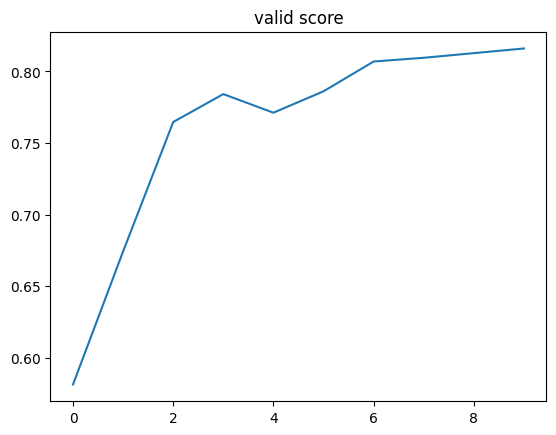

In [110]:
if __name__ == '__main__':
    main(0)